Connections that exist for most subjects after corrections only

In [1]:
import pickle
from pymania import *
import matplotlib.pyplot as plt
import pickle as pk
import numpy as np
from scipy.spatial.distance import squareform,pdist

In [4]:
from collections import defaultdict

In [8]:
rois = [f'R{i}' for i in range(1,181)]
roi2ind = {}
ind2roi = {}
for i,roi in enumerate(sorted(rois)):
    roi2ind[roi]=i
    ind2roi[i]=roi
def link_type(x,q1,q2):
    if x<q1:
        return 0#'short-range'
    elif x>q2:
        return 2#'long-range'
    else:
        return 1#'mid-range'
with open('R_ROIs.txt') as f:
    st = f.readlines()
    roi_names = [xx.strip().split('_')[1] for xx in st]

In [2]:
with open('sparse_right_37.pk','rb') as f:
    SR = pk.load(f)
with open('vdense_right_37.pk','rb') as f:
    DR = pk.load(f)

In [17]:
threshold = 5
val = np.zeros((180,180))
cnan = np.zeros((180,180),dtype='uint8')
for sub in SR.subjects:
    for i,roi1 in enumerate(['R'+str(i) for i in range(1,181)]):
        for j,roi2 in enumerate(['R'+str(i) for i in range(1,181)]):
            if i==j:continue
            tmp = SR.subjects[sub](roi1,roi2)
            xd = tmp.axonal_distance(threshold)
            if np.isnan(xd):
                cnan[i,j]+=1
                continue
            val[i,j] += xd
val[cnan==len(SR)] = np.nan
val = val/(len(SR)-cnan)

In [18]:
with open('euclidean.pk','rb') as f:
    E = pk.load(f)['r']

In [19]:
EE = squareform(E)
EE.shape

(180, 180)

In [20]:
x = []
y = []
EE = squareform(E)
for i in range(180):
    for j in range(180):
        if i==j or np.isnan(val[i,j]) or min(val[i,j],EE[i,j])<1:continue
        x.append(EE[i,j])
        y.append(val[i,j])

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Text(0,0.5,'Axonal distance')

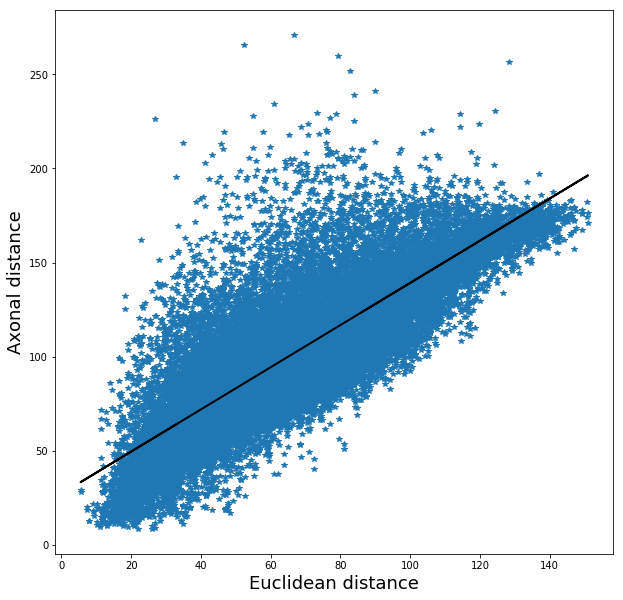

In [21]:
from sklearn.linear_model import LinearRegression
x = np.array(x)
y = np.array(y)
xr = np.array(x).reshape(-1, 1)
yr = np.array(y).reshape(-1, 1)
reg = LinearRegression().fit(xr, yr)
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(x,y,'*')
plt.plot(x,slope*x+intercept,'k-',lw=2)
plt.xlabel('Euclidean distance',fontsize=18)
plt.ylabel('Axonal distance',fontsize=18)

In [22]:
# percentage of nans (no axonal information)
100*np.count_nonzero(np.isnan(val))/180/179

17.538795779019242

In [23]:
ind = np.isnan(val)
val[ind] = slope*EE[ind] + intercept
dist = np.copy(val)

In [24]:
lengths = [dist[i,j] for i in range(179) for j in range(i+1,180)]

Text(0.5,0,'Axonal distance(mm)')

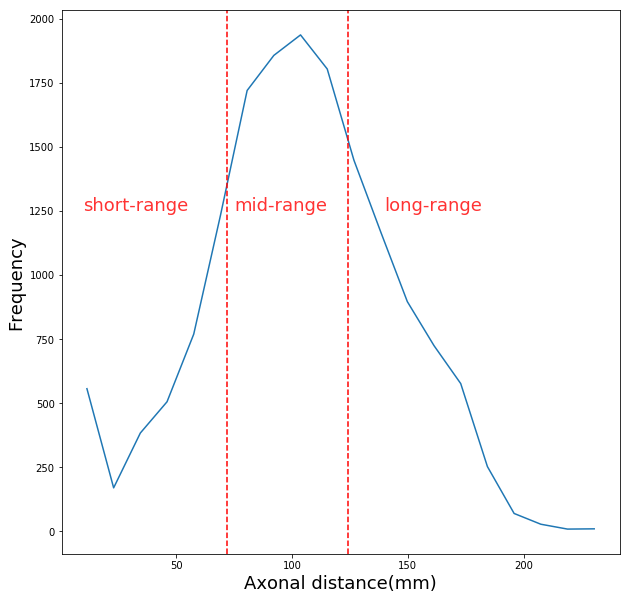

In [25]:
x,y = np.histogram(lengths, bins=20)
mid1,mid2 = np.percentile(lengths,[25,75])
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(y[1:],x)
plt.axvline(mid1,color='red',ls='dashed')
plt.axvline(mid2,color='red',ls='dashed')
plt.ylabel('Frequency',fontsize=18)
plt.text(10,1250,'short-range',fontsize=18,color='red',alpha=.8)
plt.text(75,1250,'mid-range',fontsize=18,color='red',alpha=.8)
plt.text(140,1250,'long-range',fontsize=18,color='red',alpha=.8)
plt.xlabel('Axonal distance(mm)',fontsize=18)

In [27]:
dif = np.zeros((180,180))
mid1,mid2 = np.percentile(lengths,[25,75])
p = np.zeros(3)
p1 = np.zeros(3)
p2d = np.zeros(3)
p2s = np.zeros(3)
ppd = np.zeros(3)
pps = np.zeros(3)
ds = []
for sub in SR.subjects:
    print(sub)
    net2s = SR.subjects[sub].mania2_network
    net1 = SR.subjects[sub].mania1_network
    net2d = DR.subjects[sub].mania2_network

    net10 = SR.subjects[sub].proportional_net(.1)
    dif += (net2d-net10)

    for i in range(180):
        for j in range(180):
            if i==j:continue
            roi1 = ind2roi[i]
            roi2 = ind2roi[j]
            t = dist[int(roi1[1:])-1,int(roi2[1:])-1]
            kind = link_type(t,mid1,mid2)
            p[kind]+=1
            if net10[i,j]>0.5:
                pps[kind]+=1
            if net1[i,j]>0.5:
                p1[kind]+=1
            if net2d[i,j]>0.5:
                p2d[kind]+=1
            if net2s[i,j]>0.5:
                p2s[kind]+=1

126426
135124
137431
144125
146735
152427
153227
177140
180533
186545
188145
192237
206323
227533
248238
360030
361234
362034
368753
401422
413934
453542
463040
468050
481042
825654
911849
917558
992673
558960
569965
644246
654552
680452
701535
804646
814548


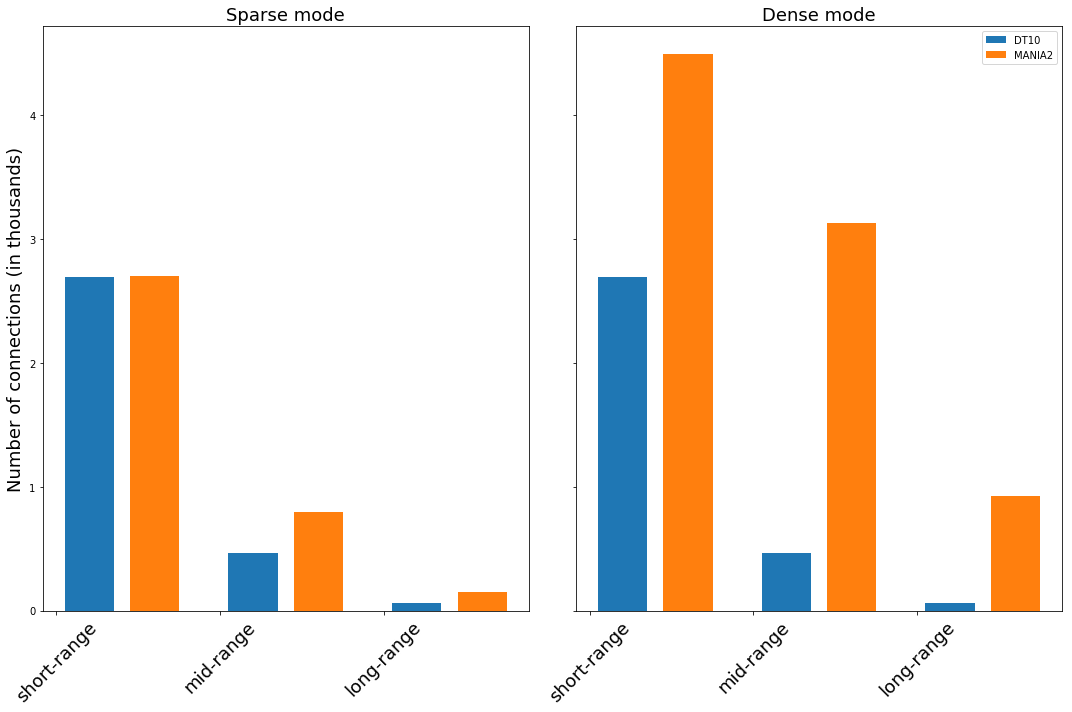

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15,10),sharey=True)
ax[0].bar([1,2,3],pps/37000,width=.3)
ax[0].bar([1.4,2.4,3.4],p2s/37000,width=.3)
ax[0].set_xticks([.8,1.8,2.8])
ax[0].set_xticklabels(['short-range','mid-range','long-range'],rotation=45,fontsize=18)

ax[1].bar([1,2,3],pps/37000,width=.3,label='DT10')
ax[1].bar([1.4,2.4,3.4],p2d/37000,width=.3,label='MANIA2')
ax[1].legend()
ax[1].set_xticks([.8,1.8,2.8])
ax[1].set_xticklabels(['short-range','mid-range','long-range'],rotation=45,fontsize=18)
# ax[1].set_ylim([0,112])
# ax[0].set_ylim([0,112])
ax[0].set_ylabel('Number of connections (in thousands)',fontsize=18)
ax[0].set_title('Sparse mode',fontsize=18)
ax[1].set_title('Dense mode',fontsize=18)
plt.tight_layout()

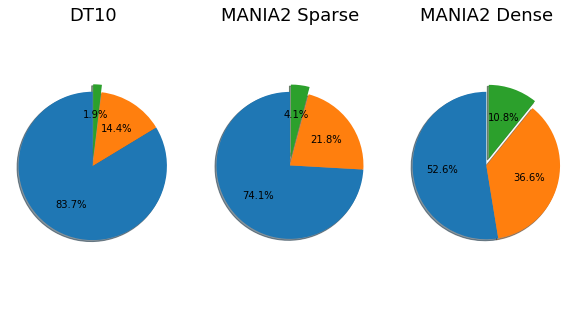

In [34]:
_p1 = 100*p1/np.sum(p1)
_p2d = 100*p2d/np.sum(p2d)
_p2s = 100*p2s/np.sum(p2s)
# _ppd = 100*ppd/np.sum(ppd)
_pps = 100*pps/np.sum(pps)
fig1, ax = plt.subplots(1,3,figsize=(10,5))
ax[2].pie(_p2d, explode=[0,0,.1], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[2].axis('equal') 

ax[1].pie(_p2s, explode=[0,0,.1], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal') 

ax[0].pie(_pps, explode=[0,0,.1], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal') 


ax[1].set_title('MANIA2 Sparse',fontsize=18)
ax[2].set_title('MANIA2 Dense',fontsize=18)
ax[0].set_title('DT10',fontsize=18)
plt.show()
plt.tight_layout()

In [51]:
q=0
print('"row"','"roi1"','"roi2"','"label1"','"label2"','"axonal distance"','"# Subjects"','"description"')
ls = []
for i in range(180):
    for j in range(180):
        if dif[i,j]>34:
            q= q+1
            roi1 = ind2roi[i]
            roi2 = ind2roi[j]
            name1 = roi_names[int(roi1[1:])-1]
            name2 = roi_names[int(roi2[1:])-1]
            i1 = int(roi1[1:])-1
            i2 = int(roi2[1:])-1
            ls += [(roi1,roi2,name1,name2,str(int(dist[i1,i2])),str(int(dif[i,j])),'XXX')]
ls = sorted(ls,key=lambda x:x[-2],reverse=True)
for i,w in enumerate(ls):
    print(str(i+1)+' '+' '.join(w))

"row" "roi1" "roi2" "label1" "label2" "axonal distance" "# Subjects" "description"
1 R143 R178 PGp PI 89 37 XXX
2 R1 R167 V1 PoI1 89 36 XXX
3 R15 R106 POS2 PoI2 83 36 XXX
4 R45 R110 7Am Pir 103 36 XXX
5 R13 R178 V3A PI 101 35 XXX
6 R131 R150 TGd PGi 102 35 XXX
7 R149 R9 PFm 3b 76 35 XXX
8 R4 R134 V2 TE2a 85 35 XXX
9 R5 R134 V3 TE2a 86 35 XXX
10 R75 R125 45 A5 116 35 XXX


In [46]:
ls

[('R143', 'R178', 'PGp', 'PI', 89, 37, ''),
 ('R1', 'R167', 'V1', 'PoI1', 89, 36, ''),
 ('R15', 'R106', 'POS2', 'PoI2', 83, 36, ''),
 ('R45', 'R110', '7Am', 'Pir', 103, 36, ''),
 ('R13', 'R178', 'V3A', 'PI', 101, 35, ''),
 ('R131', 'R150', 'TGd', 'PGi', 102, 35, ''),
 ('R149', 'R9', 'PFm', '3b', 76, 35, ''),
 ('R4', 'R134', 'V2', 'TE2a', 85, 35, ''),
 ('R5', 'R134', 'V3', 'TE2a', 86, 35, ''),
 ('R75', 'R125', '45', 'A5', 116, 35, '')]

In [169]:
vdata.subjects.keys()

dict_keys([126426, 135124, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 188145, 192237, 206323, 227533, 248238, 360030, 361234, 362034, 368753, 401422, 413934, 453542, 463040, 468050, 481042, 825654, 911849, 917558, 992673, 558960, 569965, 644246, 654552, 680452, 701535, 804646, 814548])

In [221]:
.27*37*180*179/2

160938.9